In [2]:
# !pip install pytorch-widedeep torchmetrics --quiet
!pip install category-encoders --quiet

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

from geopy.distance import great_circle
from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
# from pytorch_widedeep.models import SAINT, WideDeep
# from pytorch_widedeep.preprocessing import TabPreprocessor
# from pytorch_widedeep.training import Trainer

import os
import matplotlib.pyplot as plt
import seaborn as sns
import json

my_seed = 59

In [4]:
def read_concatenated_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read().strip()
    
    json_objects = content.split('}{')
    
    json_objects = [obj + '}' if i != len(json_objects) - 1 else obj for i, obj in enumerate(json_objects)]
    json_objects = ['{' + obj if i != 0 else obj for i, obj in enumerate(json_objects)]
    
    data = []
    for obj in json_objects:
        try:
            data.append(json.loads(obj))
        except json.JSONDecodeError as e:
            print(f"Failed to parse: {obj}\nError: {e}")
    
    return data

In [5]:
json_path = '/kaggle/input/cian-ekb-spb-kazan/offers_ekb.json'

list_of_dicts = read_concatenated_json(json_path)
print(f'Parsed {len(list_of_dicts)} deals.')

Parsed 10201 deals.


In [6]:
def filter_none_keys(data_dict):
    clear_dict = {}
    for k, v in data_dict.items():
        if type(v) in [bool, dict, int, list] or (v and v.strip()):
            clear_dict[k] = v
    return clear_dict

In [7]:
i = 0
print(filter_none_keys(list_of_dicts[i]).keys())

dict_keys(['isByHomeowner', 'isRentByParts', 'isStandard', 'newbuilding', 'repairType', 'cadastralNumber', 'hasFurniture', 'isApartments', 'exportPdfLink', 'geo', 'specialty', 'platform', 'combinedWcsCount', 'isFairplay', 'villageMortgageAllowed', 'isAuction', 'floorNumber', 'demolishedInMoscowProgramm', 'exportDocLink', 'flatType', 'gaObjectType', 'isCianPartner', 'status', 'isExcludedFromAction', 'addedTimestamp', 'isPremium', 'dealType', 'livingArea', 'basicProfiScore', 'id', 'category', 'publishTerms', 'isImported', 'windowsViewType', 'rosreestrCheck', 'descriptionMinhash', 'callTrackingProvider', 'balconiesCount', 'editDate', 'offerType', 'isMulti', 'isEnabledCallTracking', 'objectType', 'separateWcsCount', 'fromDeveloper', 'fullUrl', 'building', 'cianUserId', 'publishedUserId', 'kitchenArea', 'isColorized', 'isNeedHideExactAddress', 'added', 'description', 'isTop3', 'layoutPhoto', 'objectGuid', 'isRecidivist', 'isInHiddenBase', 'roomsCount', 'cianId', 'totalArea', 'loggiasCount',

In [8]:
def get_usefull_data(data_dict, selected_keys, city_center):
    new_data = {}
    
    for sk in selected_keys:
        if sk not in ['geo', 'building', 'bargainTerms']:
            new_data[sk] = data_dict.get(sk, np.nan)

    # nested values proc by hand
    if 'building' in selected_keys:
        building = data_dict['building']
        new_data['buildYear'] = building.get('buildYear', np.nan)
        new_data['materialType'] = building.get('materialType', np.nan)
        
    if 'geo' in selected_keys and 'geo' in data_dict:
        geo = data_dict['geo']
        try:
            lat = geo['coordinates']['lat']
            lng = geo['coordinates']['lng']
            # city_center = (55.752773, 37.623168)  # mocsow btw
            distance = great_circle((lat, lng), city_center).km
            new_data['distance_to_center'] = distance
        except (KeyError, TypeError):
            new_data['distance_to_center'] = np.nan
        
        for feature in ['highways', 'undergrounds', 'railways']:
            count = len(geo.get(feature, []))
            new_data[f'{feature}_count'] = count

    if 'bargainTerms' in selected_keys:
        new_data['price'] = data_dict['bargainTerms']['price']

    return new_data
        

In [9]:
spb_center = (59.95054055846414, 30.316514031430454)
ekb_center = (56.83538010563419, 60.611698980461185)
kazan_center = (55.78340743213986, 49.13330009590394)
selected_keys = ['geo', 'dealType', 'roomsCount', 'repairType', 'hasFurniture', 'isApartments', 'floorNumber', 'flatType', 'livingArea', 'windowsViewType', 
                 'balconiesCount', 'building', 'kitchenArea', 'isRecidivist', 'roomsCount', 'totalArea', 'hasLift', 'bargainTerms']
get_usefull_data(filter_none_keys(list_of_dicts[0]), selected_keys, ekb_center)

{'dealType': 'sale',
 'roomsCount': 1,
 'repairType': 'no',
 'hasFurniture': False,
 'isApartments': False,
 'floorNumber': 4,
 'flatType': 'rooms',
 'livingArea': '12.0',
 'windowsViewType': 'yardAndStreet',
 'balconiesCount': 0,
 'kitchenArea': '19.9',
 'isRecidivist': False,
 'totalArea': '46.4',
 'hasLift': True,
 'buildYear': 2020,
 'materialType': 'monolith',
 'distance_to_center': 2.094266582118505,
 'highways_count': 0,
 'undergrounds_count': 3,
 'railways_count': 0,
 'price': 12500000.0}

In [10]:
clear_data = [get_usefull_data(filter_none_keys(data_dict), selected_keys, spb_center) for data_dict in list_of_dicts]
print(len(clear_data))

10201


In [46]:
# ds_full = pd.DataFrame(clear_data)

ds_full = pd.read_csv('/kaggle/input/mos-spb-ekb-merged/spb_merged.csv')
print(ds_full.head())

   level_0 dealType  roomsCount repairType hasFurniture isApartments  \
0        0     sale           1   cosmetic      unknown        false   
1        1     sale           3         no      unknown        false   
2        2     sale           2       euro         true        false   
3        3     sale           2   cosmetic      unknown        false   
4        4     sale           1   cosmetic      unknown        false   

   floorNumber flatType  livingArea windowsViewType  ...  \
0            2    rooms        18.6          street  ...   
1            5    rooms        30.0            yard  ...   
2           22    rooms        18.7         unknown  ...   
3           13    rooms        29.0          street  ...   
4            5    rooms        19.0            yard  ...   

   buildings_university  education  food_buy  food_out health  leisure  \
0                   1.0         43       100       379     82        9   
1                   0.0          8        32        19    

In [47]:
ds_full.columns

Index(['level_0', 'dealType', 'roomsCount', 'repairType', 'hasFurniture',
       'isApartments', 'floorNumber', 'flatType', 'livingArea',
       'windowsViewType', 'balconiesCount', 'kitchenArea', 'isRecidivist',
       'totalArea', 'hasLift', 'buildYear', 'materialType', 'lat', 'lng',
       'distance_to_center', 'highways_count', 'undergrounds_count',
       'railways_count', 'time_to_metro', 'price', 'geometry', 'mun_district',
       'pop_dense', 'avg_age', 'self_goods_sold', 'org_num', 'entrep_num',
       'buildings_apartments', 'buildings_service', 'buildings_office',
       'buildings_school', 'buildings_commercial', 'buildings_kindergarten',
       'buildings_retail', 'buildings_hospital', 'buildings_industrial',
       'buildings_church', 'buildings_public', 'buildings_construction',
       'buildings_university', 'education', 'food_buy', 'food_out', 'health',
       'leisure', 'religion', 'services', 'shopping', 'transport'],
      dtype='object')

In [48]:
#ds_full = ds_full.drop(['Unnamed: 0', 'level_0', 'index'], axis=1)

In [49]:
ds_full['kitchenArea'] = ds_full['kitchenArea'].astype(float)
ds_full['totalArea'] = ds_full['totalArea'].astype(float)
ds_full['livingArea'] = ds_full['livingArea'].astype(float)
ds_full['isRecidivist'] = ds_full['isRecidivist'].astype(float)

In [50]:
print([col for col in ds_full.columns if ds_full[col].dtype == object])

['dealType', 'repairType', 'hasFurniture', 'isApartments', 'flatType', 'windowsViewType', 'hasLift', 'materialType', 'geometry', 'mun_district']


In [51]:
# len(ds_full['embedding'][0]), ds_full['embedding'][0]

In [52]:
# ds_full.reset_index()
# embeds_per_row = []
# for index, row in ds_full.iterrows():
#     embed_str = row['embedding'].replace('[', '').replace(']', '')
#     print(embed_str)
#     embed_array = np.fromstring(cleaned, sep=' ')
#     print(embed_array.shape)
#     break

In [53]:
print(len(ds_full.columns))
ds_full.describe()

54


,level_0,roomsCount,floorNumber,livingArea,balconiesCount,kitchenArea,isRecidivist,totalArea,buildYear,lat,...,buildings_university,education,food_buy,food_out,health,leisure,religion,services,shopping,transport
count,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.0,24388.000000,24388.000000,24388.000000,...,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000
mean,12193.500000,2.007545,6.186444,31.030281,0.308840,12.182520,0.0,58.033221,1986.544243,59.922207,...,0.550189,14.041783,34.891750,45.519231,23.437059,1.341438,1.205183,22.114196,59.208340,0.036739
std,7040.353519,0.923902,5.027000,15.685683,0.516025,5.886993,0.0,23.444131,38.224741,0.091058,...,1.764751,12.151972,23.596755,77.729268,21.495666,3.176612,1.897756,25.359537,93.351823,0.188125
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,13.700000,1756.000000,59.653221,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6096.750000,1.000000,3.000000,18.400000,0.000000,8.100000,0.0,40.000000,1972.000000,59.859795,...,0.000000,6.000000,18.000000,10.000000,8.000000,0.000000,0.000000,5.000000,10.000000,0.000000
50%,12193.500000,2.000000,5.000000,28.300000,0.000000,11.000000,0.0,53.400000,2001.000000,59.920641,...,0.000000,12.000000,31.000000,21.000000,17.000000,0.000000,0.000000,14.000000,28.000000,0.000000
75%,18290.250000,3.000000,9.000000,39.400000,1.000000,15.000000,0.0,70.000000,2010.000000,59.997505,...,0.000000,18.000000,48.000000,43.000000,31.000000,1.000000,2.000000,30.000000,71.000000,0.000000
max,24387.000000,5.000000,28.000000,166.600000,4.000000,67.000000,0.0,284.400000,2025.000000,60.241258,...,23.000000,75.000000,154.000000,618.000000,124.000000,38.000000,13.000000,191.000000,790.000000,1.000000


Максимальная и минимальная цены на квартиру:
39672230.0 5257600.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


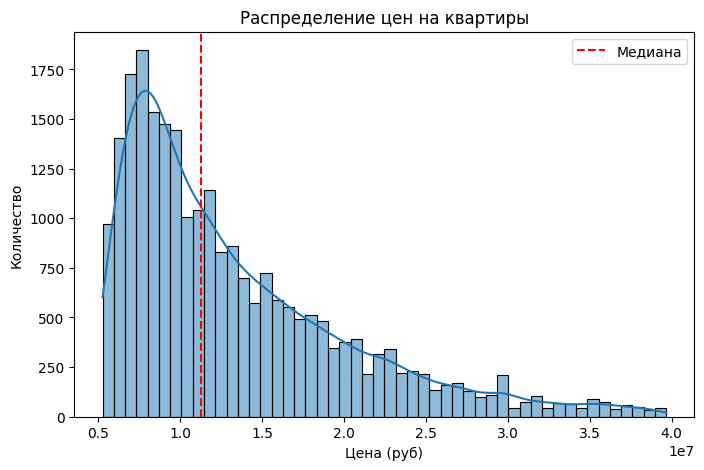

In [54]:
print('Максимальная и минимальная цены на квартиру:')
print(max(ds_full['price']), min(ds_full['price']))

plt.figure(figsize=(8, 5))
sns.histplot(ds_full['price'], bins=50, kde=True)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена (руб)')
plt.ylabel('Количество')
plt.axvline(x=ds_full['price'].median(), color='r', linestyle='--', label='Медиана')
plt.legend()
plt.show();

In [55]:
# low = ds_full['price'].quantile(0.05)
# high = ds_full['price'].quantile(0.95)
# anomalies = ds_full[((ds_full['price'] < low) | (ds_full['price'] > high))].index
# print(f'{len(anomalies)} "price" anomalies in dataset')
# ds_full.drop(anomalies, inplace=True)
# #ds_full.reset_index()
# print(len(ds_full))

In [56]:
object_cols = [col for col in ds_full.columns if ds_full[col].dtype == 'O']

for col in object_cols:
    ds_full[col] = ds_full[col].apply(lambda x: str(x).lower() if pd.notnull(x) else 'unknown')
    
print('Missing values after processing:')
print(ds_full[object_cols].isna().sum())

Missing values after processing:
dealType           0
repairType         0
hasFurniture       0
isApartments       0
flatType           0
windowsViewType    0
hasLift            0
materialType       0
geometry           0
mun_district       0
dtype: int64


In [57]:
ds_full['balconiesCount'] = ds_full['balconiesCount'].fillna(0)

build_year_median = ds_full['buildYear'].median()
ds_full['buildYear'] = ds_full['buildYear'].fillna(build_year_median)

living_area_median = ds_full['livingArea'].median()
ds_full['livingArea'] = ds_full['livingArea'].fillna(living_area_median)

kitchen_area_median = ds_full['kitchenArea'].median()
ds_full['kitchenArea'] = ds_full['kitchenArea'].fillna(kitchen_area_median)

total_area_median = ds_full['totalArea'].median()
ds_full['totalArea'] = ds_full['totalArea'].fillna(total_area_median)

In [58]:
ds_full.describe()

,level_0,roomsCount,floorNumber,livingArea,balconiesCount,kitchenArea,isRecidivist,totalArea,buildYear,lat,...,buildings_university,education,food_buy,food_out,health,leisure,religion,services,shopping,transport
count,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.0,24388.000000,24388.000000,24388.000000,...,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000,24388.000000
mean,12193.500000,2.007545,6.186444,31.030281,0.308840,12.182520,0.0,58.033221,1986.544243,59.922207,...,0.550189,14.041783,34.891750,45.519231,23.437059,1.341438,1.205183,22.114196,59.208340,0.036739
std,7040.353519,0.923902,5.027000,15.685683,0.516025,5.886993,0.0,23.444131,38.224741,0.091058,...,1.764751,12.151972,23.596755,77.729268,21.495666,3.176612,1.897756,25.359537,93.351823,0.188125
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,13.700000,1756.000000,59.653221,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6096.750000,1.000000,3.000000,18.400000,0.000000,8.100000,0.0,40.000000,1972.000000,59.859795,...,0.000000,6.000000,18.000000,10.000000,8.000000,0.000000,0.000000,5.000000,10.000000,0.000000
50%,12193.500000,2.000000,5.000000,28.300000,0.000000,11.000000,0.0,53.400000,2001.000000,59.920641,...,0.000000,12.000000,31.000000,21.000000,17.000000,0.000000,0.000000,14.000000,28.000000,0.000000
75%,18290.250000,3.000000,9.000000,39.400000,1.000000,15.000000,0.0,70.000000,2010.000000,59.997505,...,0.000000,18.000000,48.000000,43.000000,31.000000,1.000000,2.000000,30.000000,71.000000,0.000000
max,24387.000000,5.000000,28.000000,166.600000,4.000000,67.000000,0.0,284.400000,2025.000000,60.241258,...,23.000000,75.000000,154.000000,618.000000,124.000000,38.000000,13.000000,191.000000,790.000000,1.000000


In [59]:
#ds_full.drop('isRecidivist', axis=1, inplace=True)
ds_full.drop('geometry', axis=1, inplace=True)
# ds_full.drop('level_0', axis=1, inplace=True)
# ds_full.drop('index', axis=1, inplace=True)

In [60]:
selected_ds = ds_full.copy()
selected_ds.columns

Index(['level_0', 'dealType', 'roomsCount', 'repairType', 'hasFurniture',
       'isApartments', 'floorNumber', 'flatType', 'livingArea',
       'windowsViewType', 'balconiesCount', 'kitchenArea', 'isRecidivist',
       'totalArea', 'hasLift', 'buildYear', 'materialType', 'lat', 'lng',
       'distance_to_center', 'highways_count', 'undergrounds_count',
       'railways_count', 'time_to_metro', 'price', 'mun_district', 'pop_dense',
       'avg_age', 'self_goods_sold', 'org_num', 'entrep_num',
       'buildings_apartments', 'buildings_service', 'buildings_office',
       'buildings_school', 'buildings_commercial', 'buildings_kindergarten',
       'buildings_retail', 'buildings_hospital', 'buildings_industrial',
       'buildings_church', 'buildings_public', 'buildings_construction',
       'buildings_university', 'education', 'food_buy', 'food_out', 'health',
       'leisure', 'religion', 'services', 'shopping', 'transport'],
      dtype='object')

In [61]:
X, y = selected_ds.drop(['price'], axis=1), selected_ds['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=my_seed)
print(len(X_train), len(X_test), len(y_train), len(y_test))

20729 3659 20729 3659


In [62]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# high cardinality in some columns
sorted(d.items(), key=lambda x: x[1])

[('dealType', 1),
 ('flatType', 1),
 ('hasFurniture', 3),
 ('isApartments', 3),
 ('hasLift', 3),
 ('windowsViewType', 4),
 ('repairType', 5),
 ('materialType', 11),
 ('mun_district', 102)]

In [63]:
# target encoding for high cardinality
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 20]
print(low_cardinality_cols)
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
print(high_cardinality_cols)

encoder = TargetEncoder(cols=high_cardinality_cols, smoothing=10.0)

X_train_encoded = encoder.fit_transform(X_train[high_cardinality_cols], y_train)
X_test_encoded = encoder.transform(X_test[high_cardinality_cols])

X_train = pd.concat([X_train.drop(high_cardinality_cols, axis=1), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(high_cardinality_cols, axis=1), X_test_encoded], axis=1)

['dealType', 'repairType', 'hasFurniture', 'isApartments', 'flatType', 'windowsViewType', 'hasLift', 'materialType']
['mun_district']


In [64]:
import warnings
from pandas.errors import PerformanceWarning
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=PerformanceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [65]:
numeric_cols = [col for col in X_train.columns if (X_train[col].dtype in ['int64', 'float64', 'int32', 'float32'] and col != 'level_0')]
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [66]:
# ohe encoding for low cardinality

ohe_encoding = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
for col in low_cardinality_cols:
    ohe_cats_array = ohe_encoding.fit_transform(X_train[[col]])
    ohe_cats_df = pd.DataFrame(ohe_cats_array, 
                               columns=[f"{col}_{cat}" for cat in ohe_encoding.categories_[0]],
                               index=X_train.index)
    X_train = pd.concat([X_train, ohe_cats_df], axis=1).drop([col], axis=1)

    ohe_test_cats_array = ohe_encoding.transform(X_test[[col]])
    ohe_test_cats_df = pd.DataFrame(ohe_test_cats_array, 
                                    columns=[f"{col}_{cat}" for cat in ohe_encoding.categories_[0]],
                                    index=X_test.index)
    
    X_test = pd.concat([X_test, ohe_test_cats_df], axis=1).drop([col], axis=1)

X_train.head()

,level_0,roomsCount,floorNumber,livingArea,balconiesCount,kitchenArea,isRecidivist,totalArea,buildYear,lat,...,materialType_block,materialType_brick,materialType_monolith,materialType_monolithbrick,materialType_old,materialType_panel,materialType_stalin,materialType_unknown,materialType_wireframe,materialType_wood
10792,10792,-0.010285,0.559985,-0.247129,-0.596847,-0.912987,0.0,-0.607219,-0.407722,-0.548117,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10826,10826,-0.010285,-0.434305,-0.088402,1.342344,-0.726639,0.0,-0.471443,-0.747830,0.058448,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
612,612,1.071929,-0.832021,1.181414,-0.596847,-0.743580,0.0,0.623673,-3.180909,-0.113025,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11783,11783,-1.092499,0.559985,-0.831245,-0.596847,-0.879106,0.0,-0.946658,-0.276912,0.363519,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15874,15874,-0.010285,0.559985,-0.875688,-0.596847,-0.726639,0.0,-0.747237,0.377142,-1.213160,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
def save_splits_prefix(prefix):    
    X_train.to_pickle(f'x_train{prefix}.pkl') 
    y_train.to_pickle(f'y_train{prefix}.pkl') 
    X_test.to_pickle(f'x_test{prefix}.pkl') 
    y_test.to_pickle(f'y_test{prefix}.pkl') 

save_splits_prefix('_spb_merged')

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


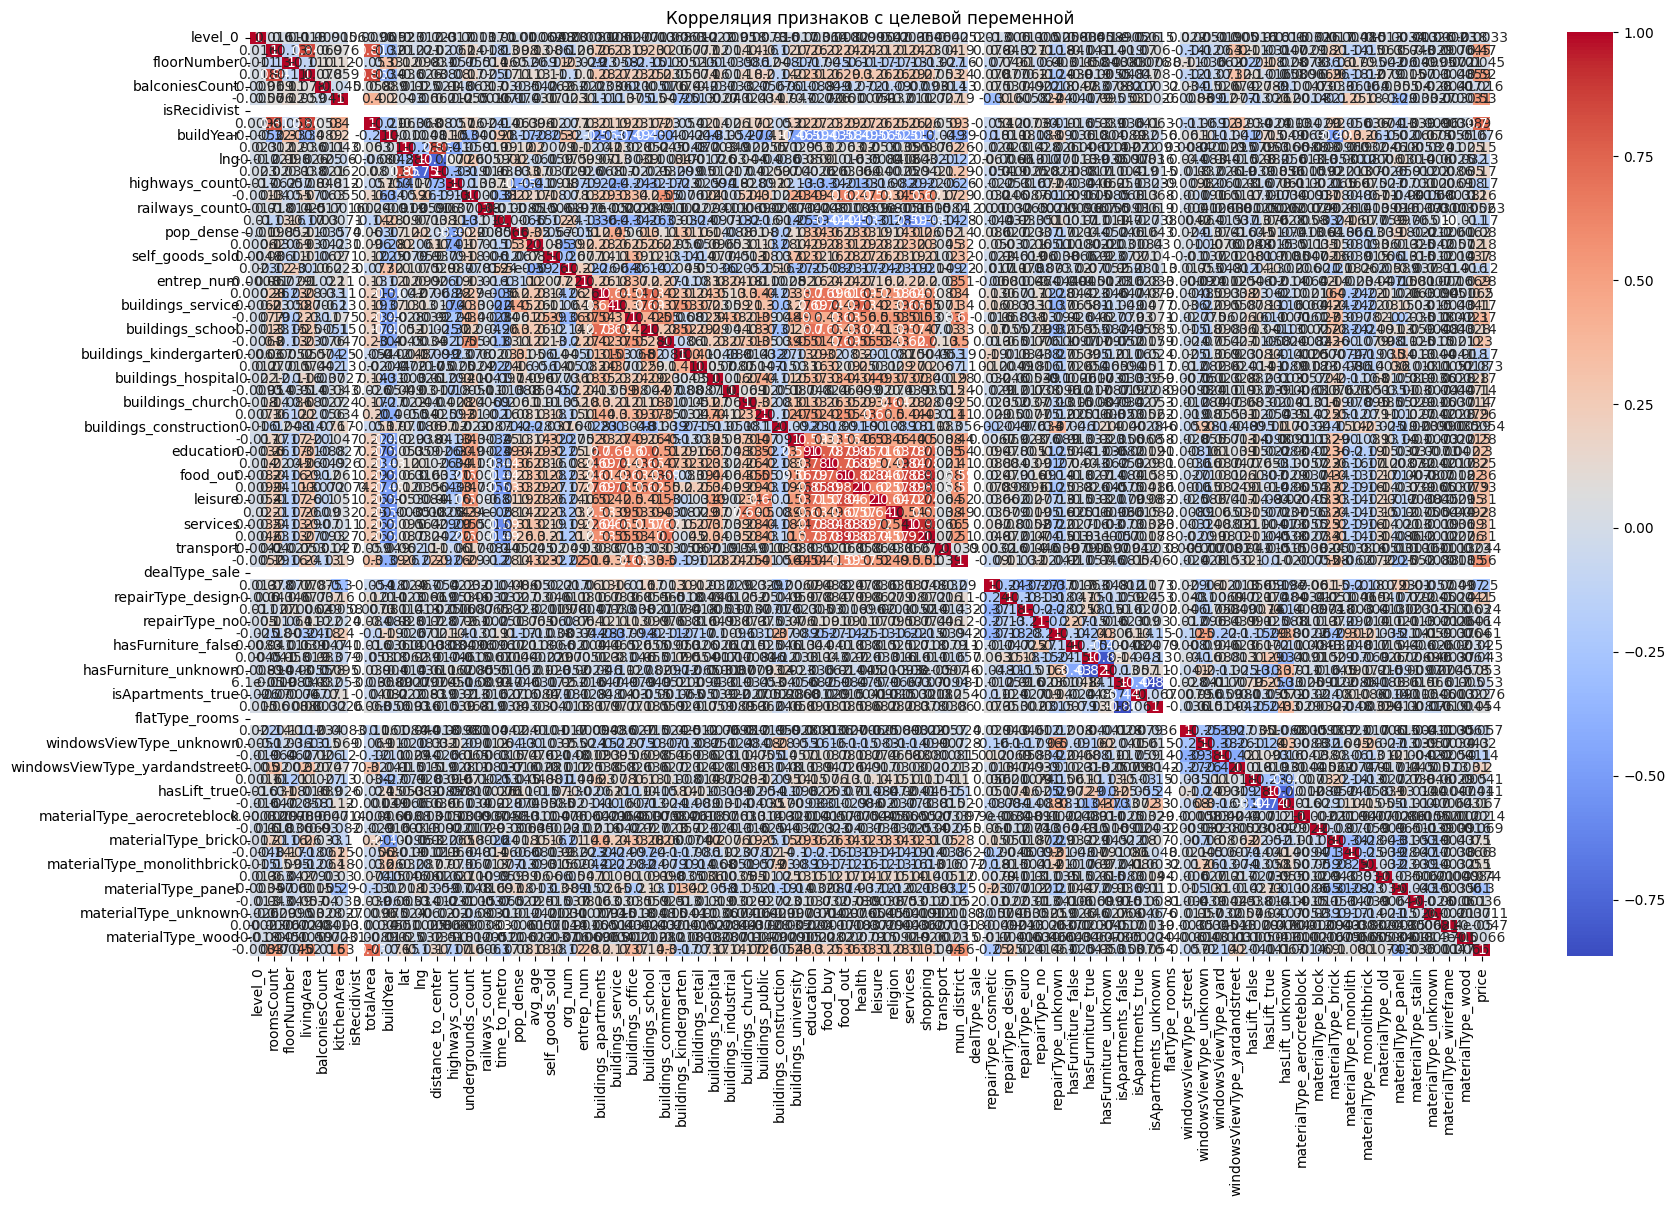

In [68]:
corr_matrix = X_train.join(y_train).corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция признаков с целевой переменной')
plt.show()

In [69]:
columns_to_exclude = ['level_0']

# Все колонки кроме исключаемых
features = [col for col in X_train.columns if col not in columns_to_exclude]

model = CatBoostRegressor(ignored_features=columns_to_exclude)
model.fit(X_train, y_train, verbose=100)

Learning rate set to 0.0661
0:	learn: 6720823.0717376	total: 7.33ms	remaining: 7.32s
100:	learn: 2715400.8391793	total: 487ms	remaining: 4.33s
200:	learn: 2398749.0674244	total: 955ms	remaining: 3.8s
300:	learn: 2198966.9228521	total: 1.42s	remaining: 3.31s
400:	learn: 2073483.7212521	total: 1.88s	remaining: 2.81s
500:	learn: 1963719.6740869	total: 2.47s	remaining: 2.46s
600:	learn: 1872488.8217294	total: 3.08s	remaining: 2.05s
700:	learn: 1794514.3587344	total: 3.63s	remaining: 1.55s
800:	learn: 1730353.2093215	total: 4.18s	remaining: 1.04s
900:	learn: 1669096.9814371	total: 4.66s	remaining: 512ms
999:	learn: 1619260.1868240	total: 5.12s	remaining: 0us


In [71]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error (RMSE):", mse**0.5)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 2054841.766909314
R² Score: 0.9051871814787682


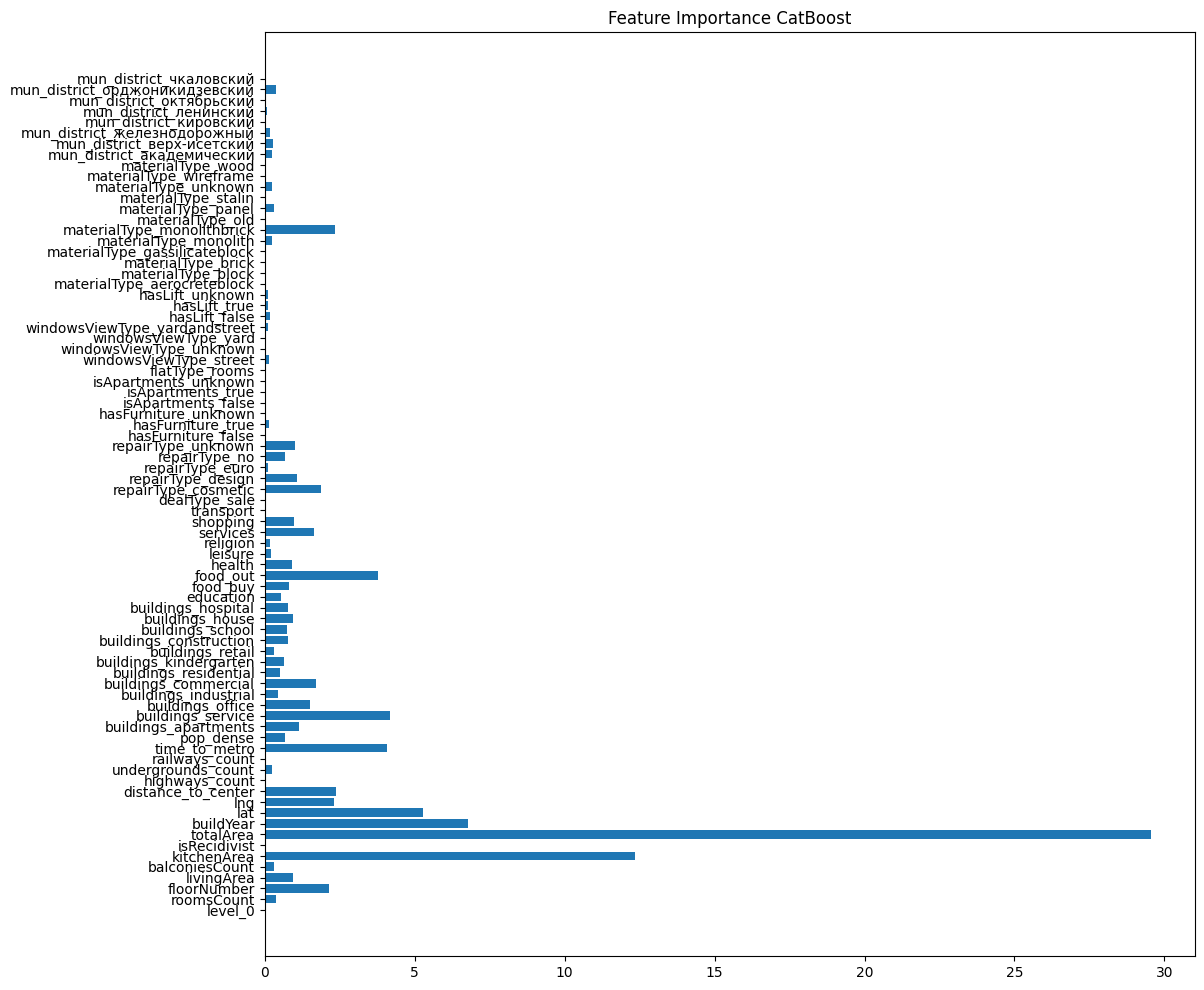

In [45]:
feature_importance = model.get_feature_importance()
plt.figure(figsize=(12, 12))
plt.barh(X_train.columns, feature_importance)
plt.title('Feature Importance CatBoost')
plt.show()

# Metrics

| method | dataset | rmse | r2 |
| --- | --- | --- | --- |
| catboost | Moscow_cian_50k | 7,386,953.65 | 0.84575 |
| | | | |
| | Moscow_merged_40k | 4,984,816.931 | 0.93111 |
| | Moscow_merged_40k_with_tabpfn_embs | 5,215,262.835 | 0.92459 |
| | Moscow_merged_40k_only_tabpfn_embs | 5,351,426.202 | 0.92060 |
| | Moscow_merged_40k_rastembeds | 4,867,027.425 | 0.9336 |
| | | | |
| | Moscow_merged_10k | 5,596,822.494 | 0.9131 |
| | Moscow_merged_10k_with_tabpfn_embs | 5,673,904.652 | 0.9107 |
| | Moscow_merged_10k_only_tabpfn_embs | 5,678,187.005 | 0.9106 |
| | | | |
| | Spb_cian_30k | 2,588,078.68 | 0.8566 |
| | Spb_merged_22k | 2,054,841.766 | 0.9052 |
| | | | |
| | Ekb_cian_10k| 1,323,669.543 | 0.81677 |everhood
| | Ekb_merged_9k | 937,373.647 | 0.91256 |
| | | | |
| tabpfn | Moscow_cian_50k | 7,891,182.802 | 0.8239 |
| | Moscow_merged_10k | 5,781,442.1704 | 0.9073 |
| | Moscow_merged_subsamples_40k | 5,596,292.617 | 0.9132 |
| | | | |
| | Spb_cian_30k | 2,552,518.7119 | 0.8605 |
| | Spb_merged_10k | 2,150,593.007 | 0.8961 |
| | | | |
| | Ekb_cian_10k | 1,218,655.8984 | 0.8447 |
| | Ekb_merged_9k | 931,941.737 | 0.9135 |
| | | | |
| saint | Moscow_merged_40k | - | - |
| | Spb_merged_22k | - | - |
| | Ekb_merged_9k | 2,380,340.84 | -0.0017 |